In [ ]:


import pandas as pd, numpy as np, re, unicodedata
from pathlib import Path
from IPython.display import display

# ---------- funciones auxiliares ----------

def sin_acentos(s: str) -> str:
    return "".join(c for c in unicodedata.normalize("NFD", s) if unicodedata.category(c) != "Mn")

MESES_MAP = {
    "enero":1,"febrero":2,"marzo":3,"abril":4,"mayo":5,"junio":6,
    "julio":7,"agosto":8,"septiembre":9,"setiembre":9,"octubre":10,
    "noviembre":11,"diciembre":12
}

def parse_yyyy_mes_es(x):
    s = str(x).strip()
    m = re.match(r"^(\d{4})[-/\s]+([A-Za-zÁÉÍÓÚáéíóúñÑ]+)$", s)
    if not m: 
        return pd.NaT
    y = int(m.group(1))
    mes_txt = sin_acentos(m.group(2).lower())
    mm = MESES_MAP.get(mes_txt)
    return pd.Timestamp(year=y, month=mm, day=1) if mm else pd.NaT

def clean_to_float(series: pd.Series) -> pd.Series:
    s = series.astype(str)

    # normaliza espacios, separadores y símbolos

    s = (s.str.replace("\u00a0", "", regex=False)  # nbsp
           .str.replace(" ", "", regex=False)
           .str.replace("--", "", regex=False))
    # Estilo latino con coma decimal (1.234,56)
    mask_coma = s.str.contains(r",\d+$") & ~s.str.contains(r"\.\d+$")
    s_lat = s[mask_coma].str.replace(".", "", regex=False).str.replace(",", ".", regex=False)

    # Estilo anglo (1,234.56) o enteros con comas
    s_eng = s[~mask_coma].str.replace(",", "", regex=False)
    s = pd.concat([s_lat, s_eng]).sort_index()
    s = s.str.replace(r"[^0-9\.-]", "", regex=True)
    return pd.to_numeric(s, errors="coerce")

# ---------- localizar raíz del proyecto ----------
root = Path.cwd()
if not (root/"data").exists() and (root.parent/"data").exists():
    root = root.parent

# ---------- cargar dataset (preferir procesado; si no, avisar) ----------
p_csv  = root / "data" / "processed" / "remesas_hn_mensual.csv"
p_xlsx = root / "data" / "processed" / "remesas_hn_mensual.xlsx"

if p_csv.exists():
    df = pd.read_csv(p_csv, dtype=str)
    origen = p_csv.name
elif p_xlsx.exists():
    df = pd.read_excel(p_xlsx, dtype=str)
    origen = p_xlsx.name
else:
    raise SystemExit("No encuentro data/processed/remesas_hn_mensual.csv/xlsx. Genera el procesado primero.")

# ---------- normalizar encabezados ----------

df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# ---------- detectar/crear FECHA ----------
date_col = None
for cand in ("fecha","periodo","date"):
    if cand in df.columns:
        date_col = cand
        break

if date_col is None and {"anio","mes"}.issubset(df.columns):
    df["fecha"] = pd.to_datetime(dict(
        year=pd.to_numeric(df["anio"], errors="coerce"),
        month=pd.to_numeric(df["mes"], errors="coerce"),
        day=1
    ), errors="coerce")
    date_col = "fecha"

if date_col is None:

    # intenta parsear la primera columna como 'YYYY-Mes'

    first = df.columns[0]
    parsed = df[first].apply(parse_yyyy_mes_es)
    if parsed.notna().sum() > 3:
        df["fecha"] = parsed
        date_col = "fecha"

if date_col is None:
    raise SystemExit("No pude identificar una columna de fecha (fecha/periodo o anio+mes o 'YYYY-Mes').")

df["fecha"] = pd.to_datetime(df[date_col], errors="coerce")

# ---------- detectar/limpiar VALOR ----------

preferidas = [c for c in ("remesas_ingreso","remesas_ingreso_usd","valor","monto") if c in df.columns]
if preferidas:
    value_col = preferidas[0]
else:

    # elige la columna con más valores numéricos válidos después de limpiar

    puntajes = {}
    for c in df.columns:
        if c == date_col: 
            continue
        conv = clean_to_float(df[c])
        puntajes[c] = conv.notna().sum()
    value_col = max(puntajes, key=puntajes.get) if puntajes else None

if value_col is None:
    raise SystemExit("No encontré columna de valores numéricos. Revisa el archivo.")

df["remesas_ingreso"] = clean_to_float(df[value_col])

# ---------- depuración final ----------

df = (df.dropna(subset=["fecha","remesas_ingreso"])
        .sort_values("fecha").reset_index(drop=True))

# columnas temporales útiles

df["año"] = df["fecha"].dt.year
df["mes"]  = df["fecha"].dt.month
df["trimestre"]  = df["fecha"].dt.quarter

print(f"Origen: {origen}")
print("Fecha detectada en:", date_col, "| Valor detectado en:", value_col)
print("Filas limpias:", len(df))
display(df.head(10))




Origen: remesas_hn_mensual.csv
Fecha detectada en: fecha | Valor detectado en: remesas_ingreso
Filas limpias: 306


,fecha,remesas_ingreso,anio,mes,tri
0,2000-01-01,20.14,2000,1,1
1,2000-02-01,27.31,2000,2,1
2,2000-03-01,29.64,2000,3,1
3,2000-04-01,26.07,2000,4,2
4,2000-05-01,34.25,2000,5,2
5,2000-06-01,26.60,2000,6,2
6,2000-07-01,27.62,2000,7,3
7,2000-08-01,32.35,2000,8,3
8,2000-09-01,30.85,2000,9,3
9,2000-10-01,32.24,2000,10,4


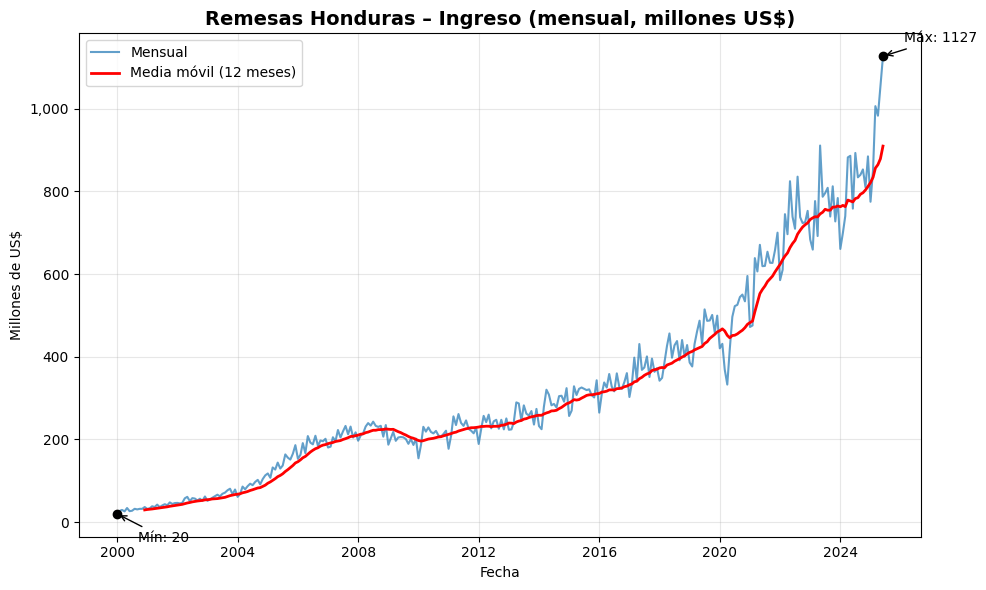

In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Crear figura y eje
fig, ax = plt.subplots(figsize=(10,6))

# Serie mensual
ax.plot(df["fecha"], df["remesas_ingreso"], label="Mensual", alpha=0.7)

# Media móvil 12 meses
ma12 = df["remesas_ingreso"].rolling(12).mean()
ax.plot(df["fecha"], ma12, label="Media móvil (12 meses)", linewidth=2, color="red")

# Puntos máximo y mínimo
pmax = df.loc[df["remesas_ingreso"].idxmax()]
pmin = df.loc[df["remesas_ingreso"].idxmin()]
ax.scatter([pmax["fecha"], pmin["fecha"]],
           [pmax["remesas_ingreso"], pmin["remesas_ingreso"]],
           color="black", zorder=3)

# Anotaciones
ax.annotate(f"Máx: {pmax['remesas_ingreso']:.0f}",
            xy=(pmax["fecha"], pmax["remesas_ingreso"]),
            xytext=(15, 10), textcoords="offset points",
            arrowprops=dict(arrowstyle="->"))
ax.annotate(f"Mín: {pmin['remesas_ingreso']:.0f}",
            xy=(pmin["fecha"], pmin["remesas_ingreso"]),
            xytext=(15, -20), textcoords="offset points",
            arrowprops=dict(arrowstyle="->"))

# Estética del gráfico
ax.set_title("Remesas Honduras – Ingreso (mensual, millones US$)", fontsize=14, weight="bold")
ax.set_xlabel("Fecha")
ax.set_ylabel("Millones de US$")
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()



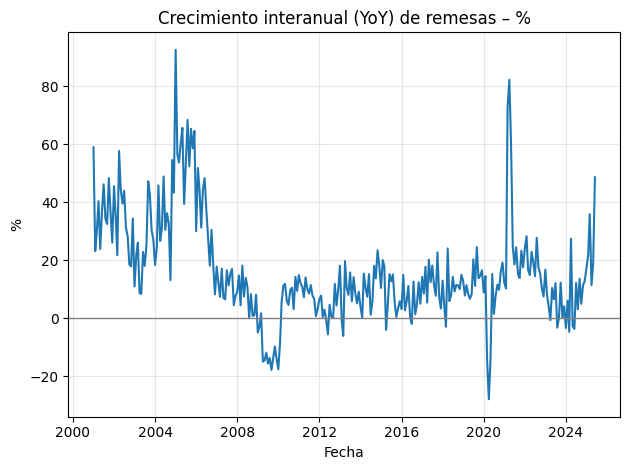

In [ ]:
df["yoy_pct"] = df["remesas_ingreso"].pct_change(12)*100

fig, ax = plt.subplots()
ax.plot(df["fecha"], df["yoy_pct"])
ax.axhline(0, color="gray", linewidth=1)
ax.set_title("Crecimiento interanual (YoY) de remesas – %")
ax.set_xlabel("Fecha"); ax.set_ylabel("%")
ax.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()


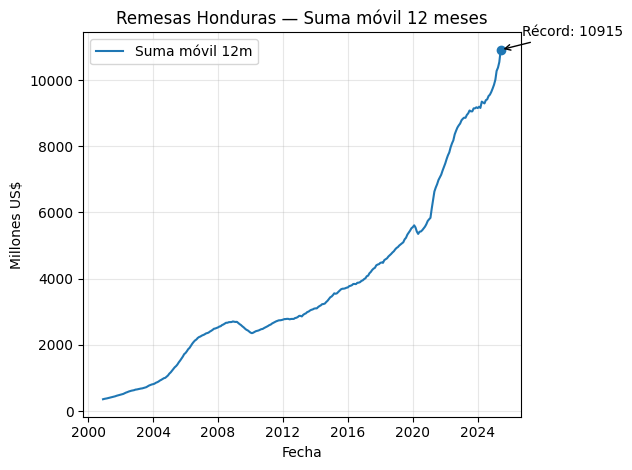

In [ ]:
import matplotlib.pyplot as plt

# crea si no existe
if "sum12" not in df.columns:
    df["sum12"] = df["remesas_ingreso"].rolling(12).sum()

fig, ax = plt.subplots()
ax.plot(df["fecha"], df["sum12"], label="Suma móvil 12m")
pmax = df.loc[df["sum12"].idxmax()]
ax.scatter(pmax["fecha"], pmax["sum12"])
ax.annotate(f"Récord: {pmax['sum12']:.0f}",
            xy=(pmax["fecha"], pmax["sum12"]),
            xytext=(15,10), textcoords="offset points",
            arrowprops=dict(arrowstyle="->"))
ax.set_title("Remesas Honduras — Suma móvil 12 meses")
ax.set_xlabel("Fecha"); ax.set_ylabel("Millones US$")
ax.grid(True, alpha=0.3); ax.legend()
plt.tight_layout(); plt.show()


CAGR total 2000-2025: 11.81%


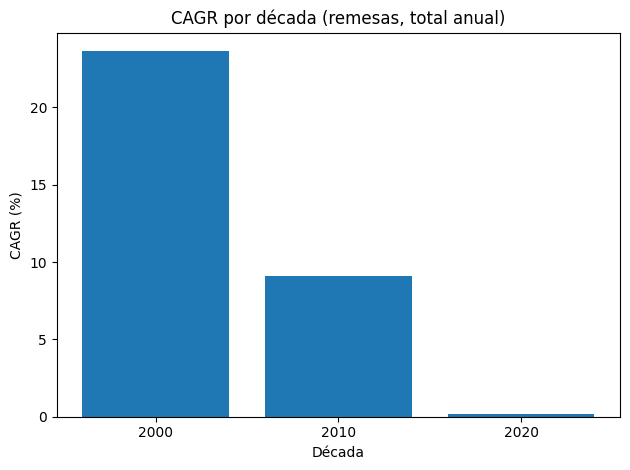

,anio,total_usd,decada,crec_anual_pct
6,2006,2251.76,2000,30.999296
7,2007,2510.14,2000,11.474580
8,2008,2707.08,2000,7.845778
9,2009,2402.85,2000,-11.238308
10,2010,2525.72,2010,5.113511
11,2011,2749.44,2010,8.857672
12,2012,2841.90,2010,3.362867
13,2013,3093.28,2010,8.845491
14,2014,3437.10,2010,11.115062
15,2015,3726.67,2010,8.424835


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Agregado anual con nombre de columna estable
annual = (
    df.assign(anio = df["fecha"].dt.year)
      .groupby("anio", as_index=False)
      .agg(total_usd=("remesas_ingreso","sum"))
)

# 2) CAGR total (primer año vs último) con checks
y0, y1 = int(annual["anio"].min()), int(annual["anio"].max())
v0 = float(annual.loc[annual["anio"]==y0, "total_usd"].iloc[0])
v1 = float(annual.loc[annual["anio"]==y1, "total_usd"].iloc[0])
n_years = y1 - y0
cagr_total = (v1/v0)**(1/n_years) - 1 if (n_years>0 and v0>0) else np.nan
print(f"CAGR total {y0}-{y1}: {cagr_total*100:.2f}%")

# 3) CAGR por década
annual["decada"] = (annual["anio"]//10)*10
rows = []
for d, g in annual.groupby("decada"):
    g = g.sort_values("anio")
    if len(g) >= 2:
        v0d = g["total_usd"].iloc[0]
        v1d = g["total_usd"].iloc[-1]
        yrs = g["anio"].iloc[-1] - g["anio"].iloc[0]
        cagr = (v1d/v0d)**(1/yrs) - 1 if (yrs>0 and v0d>0) else np.nan
        rows.append((d, cagr))
dec_cagr = pd.DataFrame(rows, columns=["decada","cagr"]).dropna()

# 4) (Opcional) gráfico de CAGR por década
plt.figure()
plt.bar(dec_cagr["decada"].astype(str), dec_cagr["cagr"]*100)
plt.title("CAGR por década (remesas, total anual)")
plt.xlabel("Década"); plt.ylabel("CAGR (%)")
plt.tight_layout(); plt.show()

# 5) (Opcional) agrega crecimiento anual % para otras gráficas
annual["crec_anual_pct"] = annual["total_usd"].pct_change()*100
annual.tail(20)


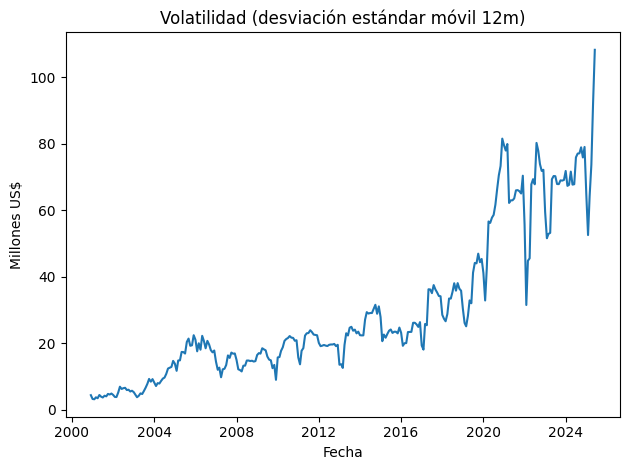

In [ ]:
df["std12"] = df["remesas_ingreso"].rolling(12).std()

plt.figure()
plt.plot(df["fecha"], df["std12"])
plt.title("Volatilidad (desviación estándar móvil 12m)")
plt.xlabel("Fecha"); plt.ylabel("Millones US$")
plt.tight_layout(); plt.show()


MAPE naive estacional (últimos 12m): 14.20%


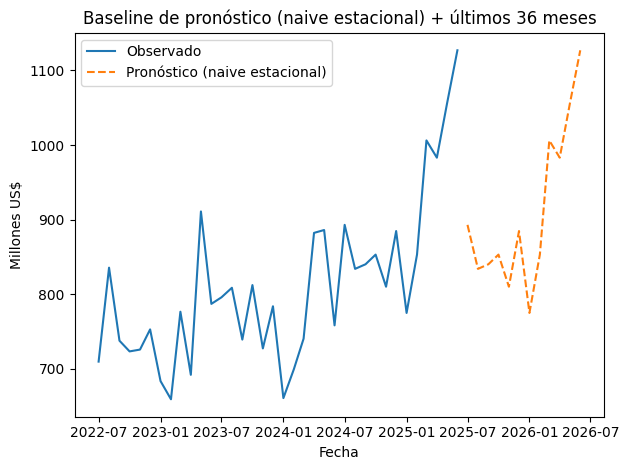

In [ ]:
# Predice mes t con el valor de t-12 (naive estacional)
df = df.sort_values("fecha").reset_index(drop=True)
df["y_hat"] = df["remesas_ingreso"].shift(12)

# Evalúa en los últimos 12 meses disponibles
test = df.dropna(subset=["y_hat"]).tail(12).copy()
mape = (np.abs((test["remesas_ingreso"] - test["y_hat"]) / test["remesas_ingreso"])).mean()*100
print(f"MAPE naive estacional (últimos 12m): {mape:.2f}%")

# Forecast próximos 12 meses = repetir último año
ultimos_12 = df.tail(12)["remesas_ingreso"].to_numpy()
f_fechas = pd.date_range(df["fecha"].iloc[-1] + pd.offsets.MonthBegin(1), periods=12, freq="MS")
f_vals = ultimos_12  # baseline

# Plota últimos 36m + forecast 12m
plt.figure()
recent = df.tail(36)
plt.plot(recent["fecha"], recent["remesas_ingreso"], label="Observado")
plt.plot(f_fechas, f_vals, linestyle="--", label="Pronóstico (naive estacional)")
plt.title("Baseline de pronóstico (naive estacional) + últimos 36 meses")
plt.xlabel("Fecha"); plt.ylabel("Millones US$")
plt.legend(); plt.tight_layout(); plt.show()


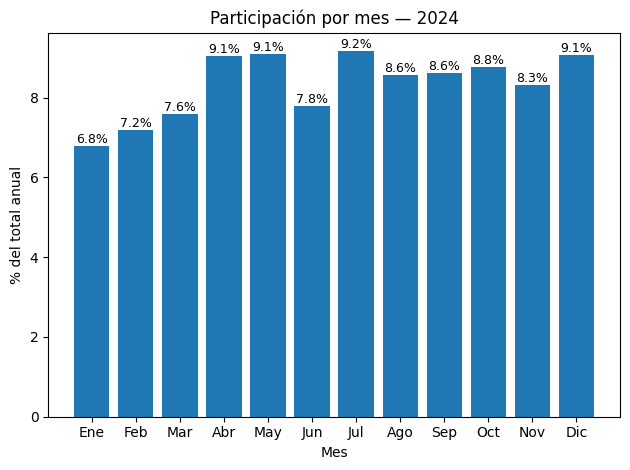

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- constante de etiquetas de meses ---
MESES = ["Ene","Feb","Mar","Abr","May","Jun","Jul","Ago","Sep","Oct","Nov","Dic"]

# asumimos que df ya existe y tiene columnas 'fecha' (datetime) y 'remesas_ingreso' (numérico)
# si no, carga tu df antes de esta celda

# columnas temporales
df["anio"] = df["fecha"].dt.year
df["mes"]  = df["fecha"].dt.month

# detectar último año completo (12 meses distintos)
counts = df.groupby("anio")["mes"].nunique()
if (counts >= 12).any():
    last_full = int(counts[counts >= 12].index.max())
    target_year = last_full
else:
    # fallback: usa el último año disponible aunque esté incompleto
    target_year = int(df["anio"].max())

yr = df.loc[df["anio"] == target_year, ["fecha","remesas_ingreso"]].copy()
yr["mes"] = yr["fecha"].dt.month
yr = yr.sort_values("mes")

share = yr["remesas_ingreso"] / yr["remesas_ingreso"].sum() * 100

plt.figure()
plt.bar([MESES[m-1] for m in yr["mes"]], share)
plt.title(f"Participación por mes — {target_year}")
plt.xlabel("Mes"); plt.ylabel("% del total anual")

# anota los % sobre cada barra
for x, val in enumerate(share):
    plt.text(x, val, f"{val:.1f}%", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


In [ ]:
# Año récord / mínimo y últimas métricas
anio_total = (df.groupby(df["fecha"].dt.year)["remesas_ingreso"].sum()
                .rename("total").to_frame())
anio_rec = int(anio_total["total"].idxmax())
anio_min = int(anio_total["total"].idxmin())

resumen = pd.DataFrame({
    "Año récord (total)": [anio_rec],
    "Año mínimo (total)": [anio_min],
    "CAGR total (%)": [round((cagr_total*100), 2)],
    "MAPE naive estac. (12m) (%)": [round(mape, 2)],
    "Promedio mensual histórico (US$M)": [round(df["remesas_ingreso"].mean(), 1)],
    "Mediana mensual histórica (US$M)": [round(df["remesas_ingreso"].median(), 1)],
})
resumen


,Año récord (total),Año mínimo (total),CAGR total (%),MAPE naive estac. (12m) (%),Promedio mensual histórico (US$M),Mediana mensual histórica (US$M)
0,2024,2000,11.81,14.2,322.3,243.5
